# LSTM Auto-Regresive Forecasting in prices of Bayo Bean using Sklearn

This is a file showing the process of developing a Deep Learning Model to forecast prices of Bayo bean taking information of weather data. This shows the process and the architecture of the model. The model developed is saved in mmodels folder, and its name is forecaster_32_2_0.0005_na_0.0054.joblib, and his metadata is in the .txt file of same name.

## Part 1: Data Adquisition
Data is taken from direct importation of the clean_data folder, the files in that folder is taken from the pipeline functions of functions folder. But it needs to prepare the prices data putting it in a csv file, and downloading data from the references shown in the weather_analysis folder, the formats can be infered from the files format.

A graph below shows a little visual of the data.

In [115]:
# importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [186]:
# Data Collection
data = pd.read_csv('weather_data/month/historic_month_stats_mean.csv')
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str) + '-01'
data.drop(columns = ['month','year'], inplace = True)
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['date'], inplace=True)
data.sort_index()

,rain,evap,t_max,t_min,date
0,0.000000,NaN,14.793548,2.951613,1921-01-01
1,0.000323,NaN,24.096774,1.516129,1923-01-01
2,0.467903,NaN,19.261290,1.870968,1924-01-01
3,0.000323,NaN,20.001613,-1.041935,1925-01-01
4,2.150161,NaN,17.569355,0.704839,1926-01-01
...,...,...,...,...,...
1197,0.863796,3.027630,21.136448,3.074604,2019-12-01
1198,0.074873,3.734301,21.739158,2.139046,2020-12-01
1199,0.162753,3.484334,24.430782,3.602829,2021-12-01
1200,0.004784,3.507152,23.134489,2.716396,2022-12-01


In [222]:
# merge prices and weather data
useful_data = data[data['date']>'1997-12-01']
bean_prices = pd.read_csv('prices_data/bayo_clean_data.csv')
bean_prices.rename(columns={'price':'bayo_price'}, inplace=True)

urea_prices = pd.read_csv('prices_data/urea_clean_data.csv')
urea_prices['date'] = urea_prices['date'].str.replace('-15','-01')
urea_prices['date'] = pd.to_datetime(urea_prices['date'])
urea_prices.rename(columns={'price':'urea_price'}, inplace=True)

bean_prices['date'] = bean_prices['date'].str.replace('-15','-01')
bean_prices['date'] = pd.to_datetime(bean_prices['date'])

useful_data = pd.merge(useful_data, bean_prices, on='date', how='outer')
useful_data = pd.merge(useful_data, urea_prices, on='date', how='outer')

useful_data.loc[0,'urea_price'] = 1680
useful_data = useful_data.loc[useful_data['date']<'2024-09-01']
# useful_data['bayo_price'] = useful_data['bayo_price'].interpolate(method='linear')
useful_data.interpolate(method='linear', inplace=True)
useful_data.set_index('date', inplace=True)
# frecuency
useful_data.index = useful_data.index + pd.offsets.MonthEnd(0)
useful_data.index.freq = 'ME'

useful_data

,rain,evap,t_max,t_min,bayo_price,urea_price
date,,,,,,
1998-01-31,0.005309,4.062765,20.107258,-0.753898,5.25,1680.0
1998-02-28,0.145870,6.037474,20.814441,-0.332143,5.58,1713.6
1998-03-31,0.001438,7.880207,25.280108,3.254301,6.00,1747.2
1998-04-30,0.015444,9.944881,28.874722,6.098889,6.00,1780.8
1998-05-31,0.000029,10.597270,32.480352,10.318182,6.00,1814.4
...,...,...,...,...,...,...
2024-04-30,0.000061,8.638768,30.507394,9.767515,30.00,9240.0
2024-05-31,0.019387,9.964817,34.705565,15.048087,32.50,9100.0
2024-06-30,2.155985,9.858769,31.969935,15.869704,35.00,10400.0


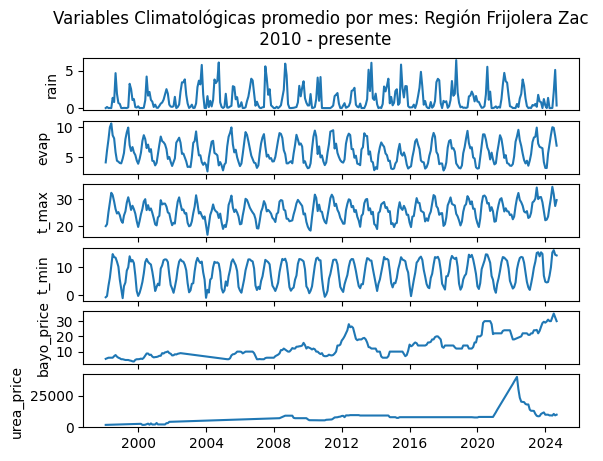

In [223]:

f, ax = plt.subplots(6,1, sharex=True)
for i in range(6):
    ax[i].plot(useful_data.index,
                useful_data[useful_data.columns[i]].values)
    ax[i].set_ylabel(useful_data.columns[i])

a1 = f.suptitle('Variables Climatológicas promedio por mes: Región Frijolera Zac \n 2010 - presente')

In [224]:
print(useful_data.info()) # to see the basic info of the Dataframe
useful_data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 320 entries, 1998-01-31 to 2024-08-31
Freq: ME
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain        320 non-null    float64
 1   evap        320 non-null    float64
 2   t_max       320 non-null    float64
 3   t_min       320 non-null    float64
 4   bayo_price  320 non-null    float64
 5   urea_price  320 non-null    float64
dtypes: float64(6)
memory usage: 17.5 KB
None


,rain,evap,t_max,t_min,bayo_price,urea_price
date,,,,,,
1998-01-31,0.005309,4.062765,20.107258,-0.753898,5.25,1680.0
1998-02-28,0.145870,6.037474,20.814441,-0.332143,5.58,1713.6
1998-03-31,0.001438,7.880207,25.280108,3.254301,6.00,1747.2
1998-04-30,0.015444,9.944881,28.874722,6.098889,6.00,1780.8
1998-05-31,0.000029,10.597270,32.480352,10.318182,6.00,1814.4
...,...,...,...,...,...,...
2024-04-30,0.000061,8.638768,30.507394,9.767515,30.00,9240.0
2024-05-31,0.019387,9.964817,34.705565,15.048087,32.50,9100.0
2024-06-30,2.155985,9.858769,31.969935,15.869704,35.00,10400.0


As we can see in the correlaction heatmap graph, the correlation between the price and the other variables is not directly correlated, but a highest correlation is shown in when we see the elasticity and the variables dependences in terms of the last 6 months, 1 year, and 2 years of elasticity. So, A deep neural network with LSTM layers is probably the best option to find the relations between them.

<Axes: >

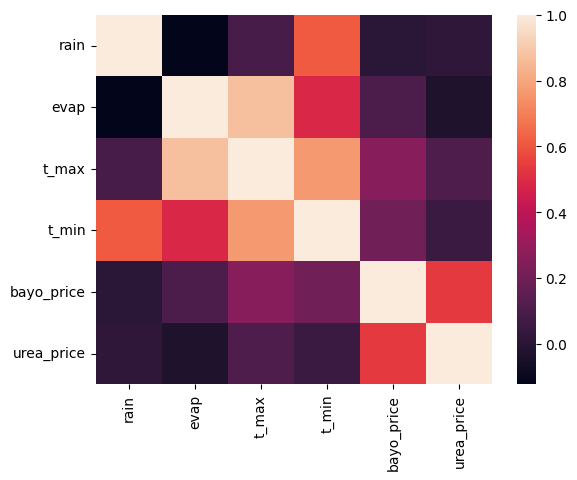

In [225]:
sns.heatmap(useful_data.corr())

## Part 2: Data preprocessing

In [228]:
# to check if the date ranges are ok
fecha_inicio = useful_data.index.min()
fecha_fin = useful_data.index.max()
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='ME')
# Obtener la fecha de inicio y fin del rango de fechas presentes 
fecha_inicio = useful_data.index.min() 
fecha_fin = useful_data.index.max() 
# Generar un rango completo de fechas para los días 15 de cada mes en el rango 
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='ME') 
# rango_completo_15 = rango_completo + pd.DateOffset(days=14) 
# rango_completo_15 = rango_completo_15[rango_completo_15 <= fecha_fin] 
# Fechas presentes 
fechas_presentes = useful_data.index
# Verificar las fechas faltantes para los días 15 
fechas_faltantes = rango_completo[~rango_completo.isin(fechas_presentes)] 
# Cuenta las fechas faltantes 
num_fechas_faltantes = len(fechas_faltantes) 
print(f"Número de fechas faltantes: {num_fechas_faltantes}") 
# Si deseas ver las fechas faltantes específicas: 
print(f'Fecha inicio: {fecha_inicio}, fecha fin: {fecha_fin}') 
print("Fechas faltantes:") 
print(fechas_faltantes)

Número de fechas faltantes: 0
Fecha inicio: 1998-01-31 00:00:00, fecha fin: 2024-08-31 00:00:00
Fechas faltantes:
DatetimeIndex([], dtype='datetime64[ns]', freq='ME')


## Part 3: Model Development and prediction
In all models I developed this is the best model. And i use 80% of data to train the model, that is like 20 years of data.

In [1022]:
train_loc = int(len(useful_data) * 0.85) # 80% of data to train
validation_loc = int(len(useful_data) * 0.95) # 80 to 95 (5%) of data to validate

train_dataset = useful_data.iloc[:train_loc]
validation_dataset = useful_data.iloc[train_loc:validation_loc]
test_dataset = useful_data.iloc[validation_loc:]

In [1023]:
train_dataset

,rain,evap,t_max,t_min,bayo_price,urea_price
date,,,,,,
1998-01-31,0.005309,4.062765,20.107258,-0.753898,5.25,1680.0
1998-02-28,0.145870,6.037474,20.814441,-0.332143,5.58,1713.6
1998-03-31,0.001438,7.880207,25.280108,3.254301,6.00,1747.2
1998-04-30,0.015444,9.944881,28.874722,6.098889,6.00,1780.8
1998-05-31,0.000029,10.597270,32.480352,10.318182,6.00,1814.4
...,...,...,...,...,...,...
2020-04-30,0.063051,8.770189,31.230494,10.610418,28.80,8000.0
2020-05-31,0.247124,8.758581,31.476799,12.181493,30.00,8000.0
2020-06-30,1.823513,7.902540,30.786880,14.401832,30.00,8000.0


In [1024]:
import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import skforecast
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

The model take the last 180 days (6 months, remember the elasticity of prices and weather elasticity) to predict the next 30 days. 

Models with a wider window of forecasting have a higher error of prediction in these wider window. And a higher complexity of the model dont makes the difference.

In [1118]:
series = ['rain','evap','t_max','t_min','bayo_price','urea_price'] # Series utilizadas
levels = ['bayo_price'] # Series a predecir
lags = 24
steps = 2


model = create_and_compile_model(
    series=train_dataset,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer='LSTM',
    recurrent_units=[45],
    dense_units=[32],
    optimizer=Adam(learning_rate=0.005),
    loss=MeanSquaredError(),
)
model.summary()



keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_101 (InputLayer)    │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 45)             │         9,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 32)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_101 (Reshape)           │ (None, 2, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,898 (42.57 KB)

 Trainable params: 10,898 (42.57 KB)

 Non-trainable params: 0 (0.00 B)

In [1119]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags,
    steps=steps,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":12,
        "batch_size":12,
        "series_val":validation_dataset,
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=4)
        ]
    },
)

forecaster.fit(train_dataset)

Epoch 1/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0382 - val_loss: 0.0468
Epoch 2/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0243 - val_loss: 0.0129
Epoch 3/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 4/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - val_loss: 0.0088
Epoch 5/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0250
Epoch 6/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0156
Epoch 7/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0295
Epoch 8/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - val_loss: 0.0192


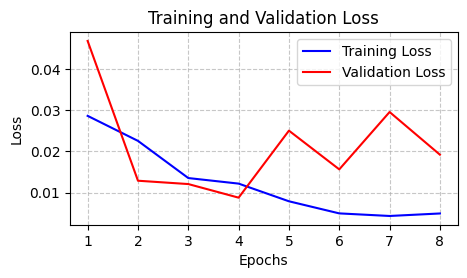

In [1120]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [1121]:
predictions = forecaster.predict()

In [1122]:
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=int(forecaster.max_step),
    series=useful_data,
    levels=forecaster.levels,
    initial_train_size=len(useful_data.iloc[:validation_loc]),
    metric='mean_absolute_error',
    verbose=False,
    refit=False
)

Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0113 - val_loss: 0.0037
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0035


100%|██████████| 8/8 [00:01<00:00,  6.64it/s]


In [1123]:
metrics

,levels,mean_absolute_error
0,bayo_price,1.965597


In [1124]:
# Error mse en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics['mean_absolute_error'].loc[0] / np.mean(useful_data["bayo_price"])
print(f"Media de la serie: {np.mean(useful_data['bayo_price']):0.2f}")
print(f"Error mae relativo: {rel_mse:0.2f} %")

Media de la serie: 12.82
Error mae relativo: 15.34 %


As we can see, I have a model with 8.49% of error

In [1125]:
predictions

,bayo_price
2023-05-31,22.431824
2023-06-30,22.525705
2023-07-31,23.219461
2023-08-31,23.102535
2023-09-30,22.907673
2023-10-31,22.750584
2023-11-30,27.138330
2023-12-31,27.084801
2024-01-31,30.649956
2024-02-29,30.837547


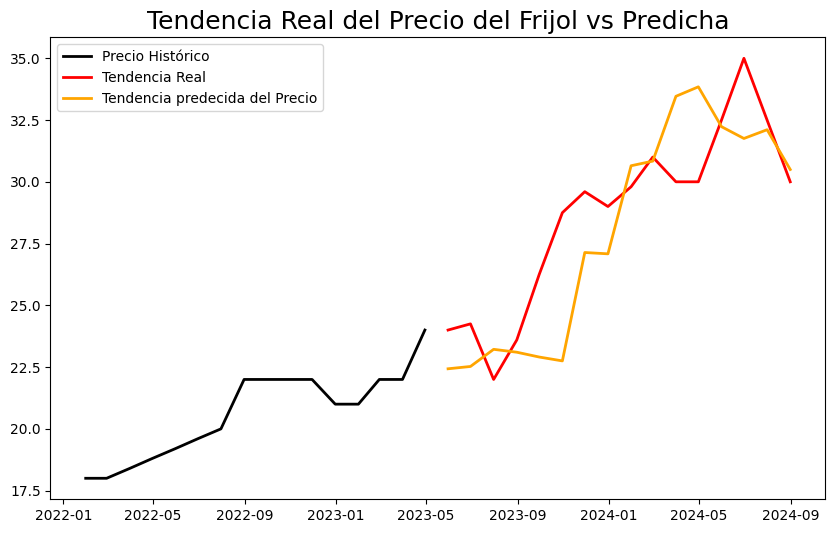

In [1126]:
plt.figure(figsize=(10,6))
plt.plot(validation_dataset.loc['2022-01-01':].index, validation_dataset['bayo_price'].loc['2022-01-01':], label = 'Precio Histórico', lw=2, color='black')
plt.plot(test_dataset.index, test_dataset['bayo_price'], label = 'Tendencia Real', color = 'red', lw = 2)
plt.plot(predictions.index, predictions['bayo_price'], label = 'Tendencia predecida del Precio', lw=2, color = 'orange')
plt.legend()
# plt.text(20240*0.865,32, f'Modelo simple_1_{epochs}_{learning_rate}_{sequence_length}_{history.history['val_loss'][-1]}', fontsize=12)
t = plt.title('Tendencia Real del Precio del Frijol vs Predicha', fontsize = 18)

In [ ]:
# from skforecast.utils import save_forecaster
# save_forecaster( forecaster=forecaster, file_name='models/forecaster_101_12_0.005_na_0.019.joblib', verbose=True)



ForecasterRnn 
Regressor: <Functional name=functional_101, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: MinMaxScaler() 
Window size: 24 
Target series, levels: ['bayo_price'] 
Multivariate series (names): ['rain', 'evap', 't_max', 't_min', 'bayo_price', 'urea_price'] 
Maximum steps predicted: [1 2] 
Training range: [Timestamp('1998-01-31 00:00:00'), Timestamp('2020-08-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: ME 
Model parameters: {'name': 'functional_101', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 24, 6), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_101'}, 'registered_name': None, 'name': 'input_layer_101', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_112', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config

ForecasterRnn 
Regressor: <Functional name=functional_101, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: MinMaxScaler() 
Window size: 24 
Target series, levels: ['bayo_price'] 
Multivariate series (names): ['rain', 'evap', 't_max', 't_min', 'bayo_price', 'urea_price'] 
Maximum steps predicted: [1 2] 
Training range: [Timestamp('1998-01-31 00:00:00'), Timestamp('2020-08-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: ME 
Model parameters: {'name': 'functional_101', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 24, 6), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_101'}, 'registered_name': None, 'name': 'input_layer_101', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_112', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config

100%|██████████| 8/8 [00:01<00:00,  7.11it/s]


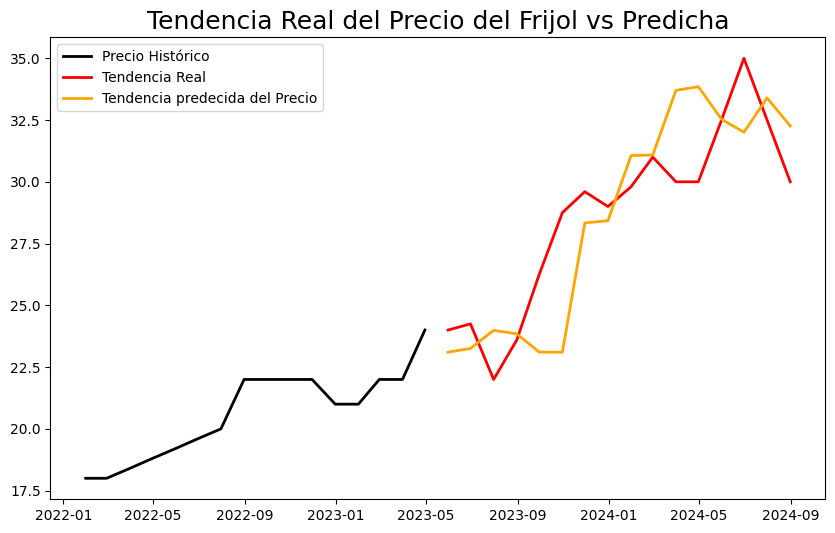

In [1135]:
#modelo preferido
from skforecast.utils import load_forecaster
prefered_forecaster = load_forecaster('models/forecaster_101_12_0.005_na_0.019.joblib')

metrics, prefered_predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=int(forecaster.max_step),
    series=useful_data,
    levels=forecaster.levels,
    initial_train_size=len(useful_data.iloc[:validation_loc]),
    metric='mean_absolute_error',
    verbose=False,
    refit=False
)

plt.figure(figsize=(10,6))
plt.plot(validation_dataset.loc['2022-01-01':].index, validation_dataset['bayo_price'].loc['2022-01-01':], label = 'Precio Histórico', lw=2, color='black')
plt.plot(test_dataset.index, test_dataset['bayo_price'], label = 'Tendencia Real', color = 'red', lw = 2)
plt.plot(prefered_predictions.index, prefered_predictions['bayo_price'], label = 'Tendencia predecida del Precio', lw=2, color = 'orange')
plt.legend()
# plt.text(20240*0.865,32, f'Modelo simple_1_{epochs}_{learning_rate}_{sequence_length}_{history.history['val_loss'][-1]}', fontsize=12)
t = plt.title('Tendencia Real del Precio del Frijol vs Predicha', fontsize = 18)